In [2]:
import tensorflow as tf
import pathlib
import tensorflow_io as tfio
import numpy as np

import os
from PIL import Image
import orjson
import cv2

import matplotlib.pyplot as plt

In [54]:
data_path = '../../fat/single'

def load_image(data_path, box):
    image = Image.open(data_path).crop(box)
    image = image.resize((128, 128))
    image = tf.cast(np.array(image), tf.int32)
    return image

def load_depth_image(data_path, box):
    image = Image.open(data_path).crop(box)
    image = image.resize((128, 128))
    image = tf.cast(np.array(image), tf.int32)
    image = image * 256 / 65536
    image = tf.expand_dims(image, -1)
    image = tf.broadcast_to(image, (128, 128, 3))
    image = tf.cast(np.array(image), tf.int32)
    return image

def sample_generator(split='train'):
    classes = os.listdir(data_path)
    scenes = os.listdir(os.path.join(data_path, classes[0]))
    if split == 'train':
        numbers = [str(im_id).zfill(6) for im_id in range(80)]
    elif split == 'test':
        numbers = [str(im_id).zfill(6) for im_id in range(80, 90)]
    else:
        numbers = [str(im_id).zfill(6) for im_id in range(90, 100)]
        
    annos = []
    for c in classes:
        for s in scenes:
            for n in numbers:
                for lr in ['left', 'right']:
                    path = os.path.join(data_path, c, s, n + '.' + lr + '.json')
                    f = open(path)
                    anno = orjson.loads(f.read())
                    if len(anno['objects']) > 0:
                        box = anno['objects'][0]['bounding_box']
                        bbox = [
                            int(box['top_left'][1]),
                            int(box['top_left'][0]),
                            int(box['bottom_right'][1]),
                            int(box['bottom_right'][0])
                        ]
                        annos.append((c, s, n, lr, bbox))
                    f.close()
    
    for c, s, n, lr, box in annos:
        rgb_image = load_image(os.path.join(data_path, c, s, n + '.' + lr + '.jpg'), box)
        depth_image = load_depth_image(os.path.join(data_path, c, s, n + '.' + lr + '.depth.png'), box)
        yield rgb_image, depth_image, c

In [55]:
ds = tf.data.Dataset.from_generator(
    sample_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

In [56]:
for image, depth, label in ds.take(1):
    i = image
    d = depth

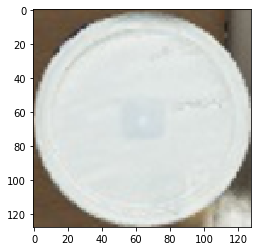

In [57]:
plt.imshow(i)

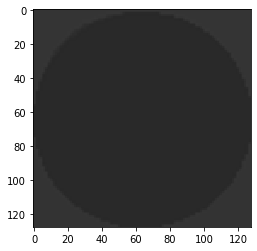

In [58]:
plt.imshow(d)